# SQUID SMILE interpolation of GPS location data

Emilio, 8/6,1/2023

Apply GPS latitude and longitude data to the `vel` data file based on interpolation on timestamps.

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd

In [2]:
base_dpth = Path("/usr/mayorgadat/workmain/SQUID/azure/msdocs-python-flask-webapp-quickstart/")

In [3]:
gps_parquet_path = "gps_points_allexperiments.parquet"
ctd_parquet_path = "ctd_points_allexperiments.parquet"
vel_parquet_path = "vel_points_allexperiments.parquet"

## Read the data (parquet files)

For the GPS file, let's load only the columsn we're interested in. That will make processing faster, as it'll consume less memory

In [4]:
gps_df = pd.read_parquet(base_dpth / gps_parquet_path)[['UXT_DT', 'LAT', 'LON', 'deployment', 'experiment']]
vel_df = pd.read_parquet(base_dpth / vel_parquet_path)

I find it helpful to examine the DataFrames a bit, for reference

In [5]:
len(gps_df), len(vel_df)

(591822, 2619890)

In [6]:
gps_df.columns

Index(['UXT_DT', 'LAT', 'LON', 'deployment', 'experiment'], dtype='object')

In [7]:
vel_df.columns

Index(['deployment', 'experiment', 'dive_nbr', 'P', 'T', 'S', 'u1', 'v1',
       'verr1', 'u2', 'v2', 'verr2', 'W', 'e1mean', 'e2mean', 'piston', 'uxt',
       'UXT_DT'],
      dtype='object')

## Merge the two DataFrames

This merging step will include columns and rows from both DataFrames. It'll have lots of empty cells ("NaN", Not-A-Number). **Before merging, we filter the two DataFrames to retain only SMILE records.**

In [8]:
vel_gps_df = (
    gps_df[gps_df.experiment == 'SMILE']
    .merge(vel_df[vel_df.experiment == 'SMILE'], how='outer')
    .set_index('UXT_DT')
)

In [9]:
len(vel_gps_df)

631603

In [10]:
vel_gps_df.head()

,LAT,LON,deployment,experiment,dive_nbr,P,T,S,u1,v1,verr1,u2,v2,verr2,W,e1mean,e2mean,piston,uxt
UXT_DT,,,,,,,,,,,,,,,,,,,
2017-03-08 05:53:59+00:00,26.238247,-146.275868,4968s1,SMILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08 05:53:59+00:00,26.238247,-146.275868,4968s1,SMILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08 05:54:00+00:00,26.238247,-146.275868,4968s1,SMILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08 05:54:00+00:00,26.238247,-146.275868,4968s1,SMILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-08 05:54:01+00:00,26.238247,-146.275868,4968s1,SMILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Interpolate latitude and longitude values on the timestamp values

Every timestamp from the `vel` DataFrame will be assigned a latitude and longitude value based on interpolation of latitudes and longitudes over the GPS timestamps.

A different interpolation method could be used, but linear seems good enough for our purposes.

In [11]:
vel_gps_df = vel_gps_df.interpolate(method='slinear').dropna(subset="v1")

In [12]:
len(vel_gps_df)

340277

In [13]:
vel_gps_df.head()

,LAT,LON,deployment,experiment,dive_nbr,P,T,S,u1,v1,verr1,u2,v2,verr2,W,e1mean,e2mean,piston,uxt
UXT_DT,,,,,,,,,,,,,,,,,,,
2017-03-08 04:51:13+00:00,26.236990,-146.269022,4968s1,SMILE,0001,38.4,20.394,35.209,0.237,-0.158,0.008,0.219,-0.115,0.007,0.159,1360.9,-1049.4,9.0,1.488949e+09
2017-03-08 04:51:40+00:00,26.237970,-146.269244,4968s1,SMILE,0001,42.6,20.355,35.205,0.207,-0.157,0.008,0.202,-0.122,0.007,0.154,1360.3,-1049.3,9.0,1.488949e+09
2017-03-08 04:52:05+00:00,26.238877,-146.269449,4968s1,SMILE,0001,46.4,20.330,35.205,0.176,-0.150,0.007,0.178,-0.122,0.007,0.154,1359.7,-1049.3,9.0,1.488949e+09
2017-03-08 04:52:30+00:00,26.239784,-146.269654,4968s1,SMILE,0001,50.2,20.317,35.204,0.175,-0.148,0.005,0.165,-0.119,0.005,0.154,1359.5,-1049.0,9.0,1.488949e+09
2017-03-08 04:52:55+00:00,26.240218,-146.269709,4968s1,SMILE,0001,54.1,20.300,35.203,0.160,-0.152,0.008,0.154,-0.123,0.007,0.153,1359.4,-1048.4,9.0,1.488949e+09


Now let's export it to a parquet file

In [14]:
# I'm commenting it out because I already exported the file in a previous run
# vel_gps_df.to_parquet(base_dpth / 'vel_gps_interpolated.parquet')

## Let's look at the issue of data from 2019

We can examine this via a histogram. `uxt` is a numeric timestmap column (seconds since 1970-01-01). As we can see, A small fraction of the data have bad timestamps, from 2019. It'd be better to go back to earlier steps and filter it out based on, say, `gps_df.UXT_DT > '2018-01-01'` and `vel_df.UXT_DT > '2018-01-01'`

In [15]:
vel_gps_df.index.min(), vel_gps_df.index.max()

(Timestamp('2017-03-07 20:18:59+0000', tz='UTC'),
 Timestamp('2019-08-08 00:04:00+0000', tz='UTC'))

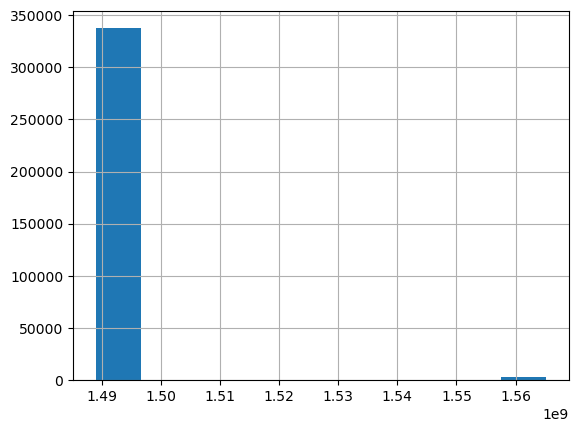

In [16]:
vel_gps_df.uxt.hist();

## Selecting only SMILE data from 2017

In [17]:
vel_gps_2017only_df = vel_gps_df[vel_gps_df.index.year == 2017]

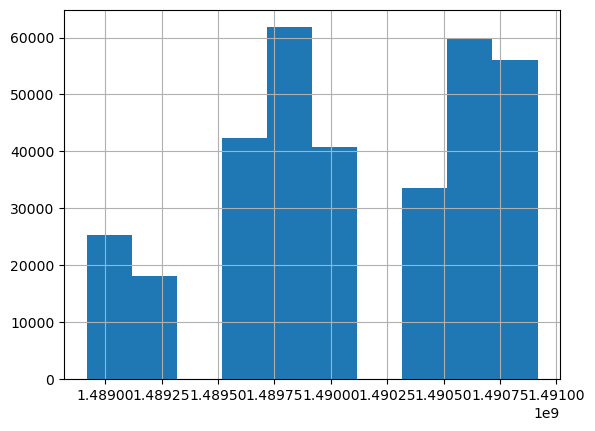

In [18]:
vel_gps_2017only_df.uxt.hist();

Now let's export it to a parquet file

In [19]:
vel_gps_2017only_df.to_parquet(base_dpth / 'vel_gps_interpolated_smile2017only.parquet')